In [1]:
import pandas as pd
import numpy as np
import math
import os
import matplotlib.pyplot as plt
import glob
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics
import pickle

In [2]:
face_points_to_keep = []
face_points_to_keep += [9]                     # Nose
face_points_to_keep += [37,38,39,40,41,42]     # Left Eye
face_points_to_keep += [43,44,45,46,47,48]     # Right Eye
face_points_to_keep += [49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59] # Outer Lip

columns_to_keep = ['mood'] + \
                    [f'px_{x}' for x in face_points_to_keep] + \
                    [f'py_{x}' for x in face_points_to_keep] +\
                    ['face_x','face_y','face_w','face_h']

def distance(table, a, b):
    return np.sqrt((table[f'px_{a}'] - table[f'px_{b}']) ** 2
                   + (table[f'py_{a}'] - table[f'py_{b}']) ** 2)

def eye_aspect_ratio(table):
	ear = (distance(table, 38, 42) + distance(table, 39, 41)) \
                / (2 * distance(table, 37, 40))
	return ear

def mouth_aspect_ratio(table):
    A = distance(table, 52, 58)
    C = distance(table, 49, 55)
    mar = (A ) / (C)
    return mar

def circularity(table):
    A = distance(table, 38, 41)
    radius  = A/2.0
    Area = math.pi * (radius ** 2)
    p = 0
    p += distance(table, 37, 38)
    p += distance(table, 38, 39)
    p += distance(table, 39, 40)
    p += distance(table, 40, 41)
    p += distance(table, 41, 42)
    p += distance(table, 42, 37)
    return 4 * math.pi * Area /(p**2)

def mouth_over_eye(table):
    mouth_eye = table['MAR'] / table['EAR']
    return mouth_eye


def get_table(index, base_path=None):
    # Find File
    if base_path is None:
        base = 'CSV_DATA'
    else:
        base = base_path

    files = glob.glob(os.path.join(base, f'{index}.csv'))

    # Load
    table = pd.read_csv(files[0])

    # Drop columns we don't need
    table = table.filter(columns_to_keep)
    
    table = table[::3]
    
    # Fill missing data
    table.replace(-1, np.NaN, inplace=True)
    table.interpolate(inplace=True, limit_direction='both')

    # Fix Data Types
    table[['mood']] = table[['mood']].astype('int32')

    return table


# process all data files
def filter_col(table):
    features = ['mood', 'EAR_N', 'MAR_N', 'PUC_N', 'MOE_N']

    table['EAR'] = eye_aspect_ratio(table)
    table['MAR'] = mouth_aspect_ratio(table)
    table['PUC'] = circularity(table)
    table['MOE'] = mouth_over_eye(table)

    table['MOE'] = table['MOE'].replace([np.inf, -np.inf], np.nan) 
    table.interpolate(inplace=True, limit_direction='both')
    
    table["EAR_N"] = (table["EAR"] - table["EAR"].mean()) / table["EAR"].std()
    table["MAR_N"] = (table["MAR"] - table["MAR"].mean()) / table["MAR"].std()
    table["PUC_N"] = (table["PUC"] - table["PUC"].mean()) / table["PUC"].std()
    table["MOE_N"] = (table["MOE"] - table["MOE"].mean()) / table["MOE"].std()
    #     table.filter(features)
    return table[features]

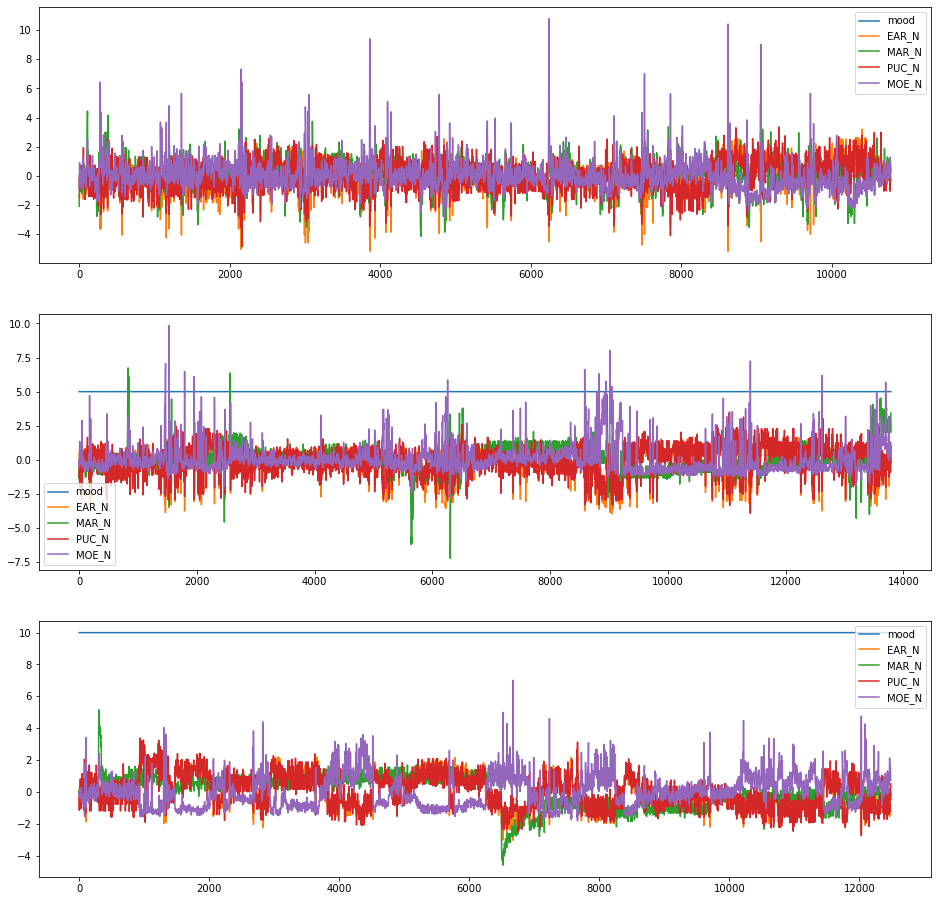

In [16]:
df0 = get_table('32_0')
df0 = filter_col(df0)

df5 = get_table('32_5')
df5 = filter_col(df5)

df10 = get_table('32_10')
df10 = filter_col(df10)

fig, axes = plt.subplots(3, 1, figsize=(16, 16))
axes[0].plot(df0)
axes[0].legend([col for col in df0.columns])
axes[1].plot(df5)
axes[1].legend([col for col in df0.columns])
axes[2].plot(df10)
axes[2].legend([col for col in df0.columns])

In [17]:
def check_csv(file):
    df = pd.read_csv(file)
    return False if (df['px_1'] != -1).sum() <= 1 \
    else True
    
files = glob.glob(os.path.join('CSV_DATA', '*.csv'))
valid_file = list(filter(check_csv, files))

In [18]:
def extract_participants(files):
    return [os.path.basename(file).split('.')[0] for file in files]

valid_index = extract_participants(valid_file)

In [5]:
print(len(valid_index))

180


In [19]:
def create_data(index, frame_to_keep=150, start=150, 
         train_percentage=17/22, base_path=None):
    df = get_table(index)
    df = filter_col(df)
    df.drop(df.columns[0], axis=1, inplace=True)
    train_index = int((len(df)-start)*train_percentage)
    print(f'{index}: {df.isnull().sum().sum()}')
    # get 4 features of each frame in 450 consecutive frames (15s)
    # and concat it into a vector
    X = [df[index-frame_to_keep:index].to_numpy().reshape(frame_to_keep*4)
              for index in range(start, len(df))]
    mood = index.split('_')[1]
    y = np.full((len(df)-start, 1), mood, dtype=int).squeeze()
    y[y != 0] = 1
    X_train = np.array(X[:train_index])
    X_test = np.array(X[train_index:])
    
    y_train = y[:train_index]
    y_test = y[train_index:]
    return X_train, y_train, X_test, y_test

In [20]:
def train(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print('Accuracy:', f'{acc*100}%')
    print(confusion_matrix(y_test, y_pred))

In [21]:
def pipeline(model, val=valid_index):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    for index in val:
        X_train1, y_train1, X_test1, y_test1 = create_data(index)
        
        X_train += [X_train1]
        y_train += [y_train1]
        X_test += [X_test1]
        y_test += [y_test1]
        

    X_train = np.concatenate(X_train, axis = 0)
    y_train = np.concatenate(y_train, axis = 0)
    X_test = np.concatenate(X_test, axis = 0)
    y_test = np.concatenate(y_test, axis = 0)
    
    print(f'Train data: {X_train.shape}')
    print(f'Test data: {X_test.shape}')
    
    train(model, X_train, y_train, X_test, y_test)
    return model

In [23]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 10, weights = 'uniform')
model = pipeline(knn)

10_0: 0
10_10: 0
10_5: 0
11_0: 0
11_10: 0
11_5: 0
12_0: 0
12_10: 0
12_5: 0
13_0: 0
13_10: 0
13_5: 0
14_0: 0
14_10: 0
14_5: 0
15_0: 0
15_10: 0
15_5: 0
16_0: 0
16_10: 0
16_5: 0
17_0: 0
17_10: 0
17_5: 0
18_0: 0
18_10: 0
18_5: 0
19_0: 0
19_10: 0
19_5: 0
1_0: 0
1_10: 0
1_5: 0
20_0: 0
20_10: 0
20_5: 0
21_0: 0
21_10: 0
21_5: 0
22_0: 0
22_10: 0
22_5: 0
23_0: 0
23_10: 0
23_5: 0
24_0: 0
24_10: 0
24_5: 0
25_0: 0
25_10: 0
25_5: 0


ParserError: Error tokenizing data. C error: out of memory

In [22]:
from sklearn.svm import SVC
svm = SVC()

model = pipeline(svm)

10_0: 0
10_10: 0
10_5: 0
11_0: 0
11_10: 0
11_5: 0
12_0: 0
12_10: 0
12_5: 0
13_0: 0
13_10: 0
13_5: 0
14_0: 0
14_10: 0
14_5: 0
15_0: 0
15_10: 0
15_5: 0
16_0: 0
16_10: 0
16_5: 0
17_0: 0
17_10: 0
17_5: 0
18_0: 0
18_10: 0
18_5: 0
19_0: 0
19_10: 0
19_5: 0
1_0: 0
1_10: 0
1_5: 0
20_0: 0
20_10: 0
20_5: 0
21_0: 0
21_10: 0
21_5: 0
22_0: 0
22_10: 0
22_5: 0
23_0: 0
23_10: 0
23_5: 0
24_0: 0
24_10: 0
24_5: 0
25_0: 0
25_10: 0
25_5: 0
26_0: 0
26_10: 0
26_5: 0
27_0: 0
27_10: 0
27_5: 0
28_0: 0
28_10: 0
28_5: 0
29_0: 0
29_10: 0
29_5: 0
2_0: 0
2_10: 0
2_5: 0
30_0: 0
30_10: 0
30_5: 0
31_0: 0
31_10: 0
31_5: 0
32_0: 0
32_10: 0
32_5: 0
33_0: 0
33_10: 0
33_5: 0
34_0: 0
34_10: 0
34_5: 0
35_0: 0
35_10: 0
35_5: 0
36_0: 0
36_10: 0
36_5: 0
37_0: 0
37_10: 0
37_5: 0
38_0: 0
38_10: 0
38_5: 0
39_0: 0
39_10: 0
39_5: 0
3_0: 0
3_10: 0
3_5: 0
40_0: 0
40_10: 0
40_5: 0
41_0: 0
41_10: 0
41_5: 0
42_0: 0
42_10: 0
42_5: 0
43_0: 0
43_10: 0
43_5: 0
44_0: 0
44_10: 0
44_5: 0
45_0: 0
45_10: 0
45_5: 0
46_0: 0
46_10: 0
46_5: 0
47_0: 0
4

MemoryError: Unable to allocate 3.38 GiB for an array with shape (755420, 600) and data type float64

In [ ]:
filename = 'final_model.sav'
pickle.dump(model, open(filename, 'wb'))